In [30]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers


In [31]:
df_train = pd.read_csv('data/sign_mnist_train.csv')
df_test = pd.read_csv('data/sign_mnist_test.csv')

df_train.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [32]:
labels = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'.split()

df_train['letter_label'] = df_train['label'].apply(lambda x: labels[x])
df_test['letter_label'] = df_test['label'].apply(lambda x: labels[x])


In [33]:
df_train.shape, df_test.shape


((27455, 786), (7172, 786))

<Axes: title={'center': 'Data distribution'}, xlabel='letter_label'>

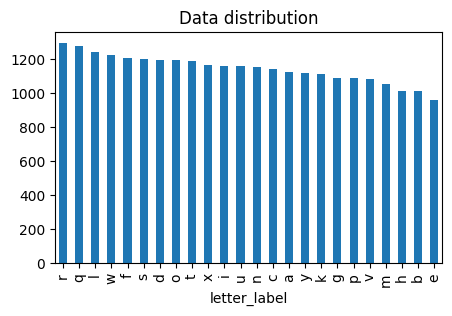

In [34]:
df_train['letter_label'].value_counts().plot.bar(title='Data distribution', figsize=(5, 3))


In [35]:
import numpy as np

try:
    df_train.drop(columns={'img'}, inplace=True)
    df_test.drop(columns={'img'}, inplace=True)
except:
    pass

pixels = [x for x in df_train.columns if 'pixel' in x]
df_train['img'] = df_train[pixels].values.tolist()
df_test['img'] = df_test[pixels].values.tolist()
df_train['img'] = df_train['img'].apply(lambda x: tf.convert_to_tensor(list(map(lambda y: int(y) / 255.0, x))))
df_test['img'] = df_test['img'].apply(lambda x: tf.convert_to_tensor(list(map(lambda y: int(y) / 255.0, x))))


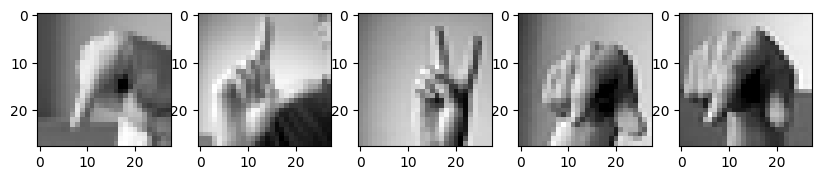

In [36]:
import random

fig, axis = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))

for i in range(5):
    axis[i].imshow(np.array(random.choice(df_train['img'])).reshape(28, 28), cmap='gray')


In [37]:

def create_dataset(df) -> tf.data.Dataset:
    images = df['img'].values.tolist()
    labels = df['label'].values.tolist()

    images = list(map(lambda x: tf.reshape(x, (28, 28, 1)), images))

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset, test_dataset = create_dataset(df_train), create_dataset(df_test)


In [38]:
DEBUG = True

if not DEBUG:
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(26, activation='softmax')
    ])

else:
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(26, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 1600)              0         
                                                                 
 dense_7 (Dense)             (None, 26)               

In [39]:
batch_size = 32
train_dataset = train_dataset.shuffle(len(df_train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [40]:
if DEBUG:
    epochs = 1
else:
    epochs = 10
model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)


858/858 [==============================] - 14s 13ms/step - loss: 0.9018 - accuracy: 0.7464 - val_loss: 0.4948 - val_accuracy: 0.8461


In [41]:
model.save('models/test_saved')


INFO:tensorflow:Assets written to: models/test_saved/assets


INFO:tensorflow:Assets written to: models/test_saved/assets


In [42]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 28, 28, 1)
      yield [data.astype(np.float32)]


In [43]:
converter = tf.lite.TFLiteConverter.from_saved_model('models/test_saved')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

converter.representative_dataset = representative_dataset
tflite_quant_model = converter.convert()


2023-12-02 01:13:12.212926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-02 01:13:12.212951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-02 01:13:12.213118: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: models/test_saved
2023-12-02 01:13:12.213999: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-02 01:13:12.214005: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: models/test_saved
2023-12-02 01:13:12.216215: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-02 01:13:12.253631: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/test_saved
2023-12-02 01:13:12.264739: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 5163

In [44]:
with open('models/test_saved/quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)


In [45]:
interpreter = tf.lite.Interpreter('models/test_saved/quant.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [46]:
def predict(debug=True):
    random_idx = random.randint(0, len(df_test))
    input_data = np.array(df_test['img'][random_idx]).reshape(28, 28, 1).astype(np.float32)
    label = df_test['letter_label'][random_idx]

    interpreter.set_tensor(input_details[0]['index'], [input_data])
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    output_label = labels[tf.argmax(output_data[0])]

    if debug:
        print(f"Predicted: {output_label}, Expected: {label}")

    return output_label == label



In [47]:
results = []
for _ in range(1000):
    results.append(predict(debug=False))

print(f"Got {sum(results)} correct predictions out of {len(results)}")


Got 778 correct predictions out of 1000
